# Data Engineering and Visualization

In [1]:
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
csv_files = glob.glob('*.csv')
csv_files

['USDEUR=X.csv', 'USDCHF=X.csv', 'USDGBP=X.csv']

In [3]:
#personal preference
filepath=['USDEUR=X.csv','USDGBP=X.csv','USDCHF=X.csv']

In [4]:
df_train=[]
df_test=[]
df_raw=[]
for path in filepath:
    df_temp=pd.read_csv(path)
    #We no longer need date, because we can use index.
    df_temp=df_temp[['Close']]
    df_temp.columns=['rate']
    # Somehow USDCHF=X.csv has one more day 2023/11/4, which shouldn't exist.
    if (path=='USDCHF=X.csv'):
        df_temp.drop(df_temp.index[-1], inplace=True)
    df_raw.append(df_temp)
    df_train.append(df_temp[:-5])
    df_test.append(df_temp[-5:])

In [5]:
for i in range(3):
    print(len(df_raw[i]))

2610
2610
2610


In [6]:
# There is something wrong with the files downloaded from the website.
# These rows shouldn't be nan.
# In this case, we simply adopt a strategy of dropping these rows.
# 2017/7/11 2017/11/16 2019/5/22
for i in range(len(filepath)):
    rows_with_nan = df_train[0][df_train[0].isna().any(axis=1)].index
    print(rows_with_nan)
for i in range(len(filepath)):
    df_train[i]=df_train[i].dropna()

Index([961, 1053, 1447], dtype='int64')
Index([961, 1053, 1447], dtype='int64')
Index([961, 1053, 1447], dtype='int64')


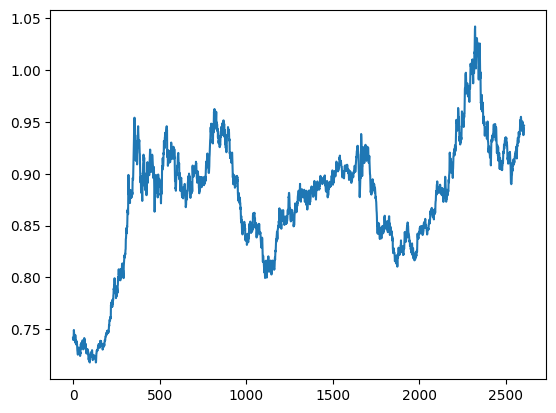

In [7]:
plt.plot(np.array(df_train[0].index),np.array(df_train[0])[:])

In [8]:
def test_stationarity(timeseries):
    # execute Dickey-Fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    print(f'p-value={dftest[1]}')

In [9]:
# First order difference is enough to make timeseries stationary, beacuase p-value<0.05. 
for i in range(len(filepath)):
    print(f"{i}:")
    test_stationarity(df_train[i]['rate'])
    #test first-order difference
    test_stationarity(df_train[i]['rate'].diff().dropna())

0:
p-value=0.2190404265400342
p-value=0.0
1:
p-value=0.342504520388928
p-value=0.0
2:
p-value=0.04668140961050518
p-value=0.0


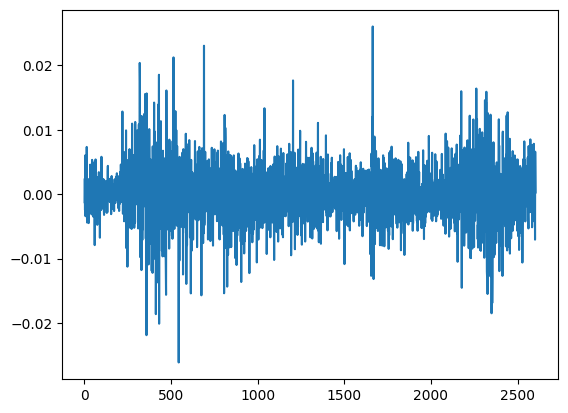

In [10]:
# By utilizing first order difference, we have made the timeseries stationary
plt.plot(df_train[0].diff().dropna())

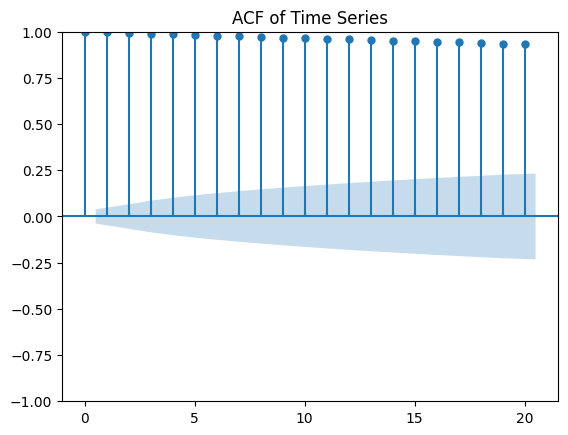

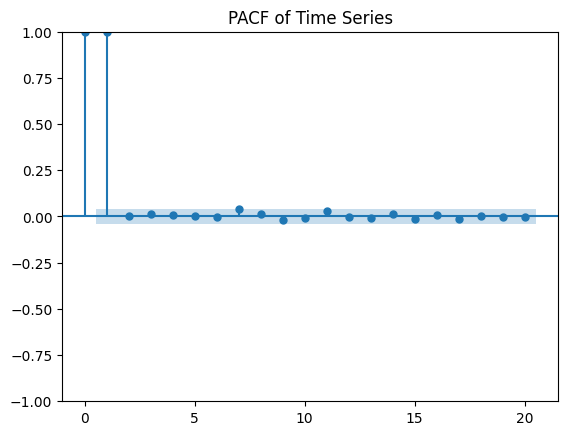

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plot ACF figure
plot_acf(df_train[0], lags=20)
plt.title('ACF of Time Series')
plt.show()

# plot PACF figure
plot_pacf(df_train[0], lags=20)
plt.title('PACF of Time Series')
plt.show()

# Prophet

In [12]:
!pip3 install prophet 
!pip3 install --upgrade plotly
!pip3 install pandas_market_calendars
!pip3 install --upgrade pandas
from prophet import Prophet
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [13]:
# As prophet needs datetime and numeric value as input, I will re-process the input data here
filepath=['USDEUR=X.csv','USDGBP=X.csv','USDCHF=X.csv']
df_train_prophet=[]
df_test_prophet=[]
df_all_prophet = []
for path in filepath:
    df_temp=pd.read_csv(path)[["Date", "High"]] # keep both Date and High
    df_temp = df_temp.rename(columns={"Date": "ds", "High": "y"})
    df_train_prophet.append(df_temp[:-5])
    df_test_prophet.append(df_temp[-5:])
    df_all_prophet.append(df_temp)

In [14]:
df_train_prophet[0]

,ds,y
0,2013-11-04,0.743770
1,2013-11-05,0.743510
2,2013-11-06,0.742460
3,2013-11-07,0.751552
4,2013-11-08,0.750677
...,...,...
2600,2023-10-23,0.945910
2601,2023-10-24,0.944800
2602,2023-10-25,0.946360
2603,2023-10-26,0.950000


In [15]:
df_test_prophet[0]

,ds,y
2605,2023-10-30,0.94801
2606,2023-10-31,0.94629
2607,2023-11-01,0.95031
2608,2023-11-02,0.94480
2609,2023-11-03,0.94202


In [16]:
prophet_models = []

for curve_data in df_train_prophet:
    model = Prophet()
    model.fit(curve_data)

    last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
    # Create a date range for the next 5 trading days, excluding weekends
    future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
    # Create a DataFrame with these dates
    future_df = pd.DataFrame({'ds': future_dates})
    # Make predictions
    forecast = model.predict(future_df)
    # Store the model and its forecast in a list
    prophet_models.append((model, forecast))

11:52:52 - cmdstanpy - INFO - Chain [1] start processing
11:52:52 - cmdstanpy - INFO - Chain [1] done processing
11:52:52 - cmdstanpy - INFO - Chain [1] start processing
11:52:53 - cmdstanpy - INFO - Chain [1] done processing
11:52:53 - cmdstanpy - INFO - Chain [1] start processing
11:52:53 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
prophet_models[0][1]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-10-30,0.960599,0.935818,0.990323,0.960599,0.960599,0.002829,0.002829,0.002829,-0.001183,-0.001183,-0.001183,0.004012,0.004012,0.004012,0.0,0.0,0.0,0.963428
1,2023-10-31,0.960669,0.934971,0.991609,0.960669,0.960669,0.003448,0.003448,0.003448,-0.001008,-0.001008,-0.001008,0.004456,0.004456,0.004456,0.0,0.0,0.0,0.964117
2,2023-11-01,0.960739,0.935827,0.992835,0.960739,0.960739,0.003900,0.003900,0.003900,-0.001026,-0.001026,-0.001026,0.004927,0.004927,0.004927,0.0,0.0,0.0,0.964639
3,2023-11-02,0.960808,0.937658,0.995928,0.960808,0.960808,0.004726,0.004726,0.004726,-0.000691,-0.000691,-0.000691,0.005417,0.005417,0.005417,0.0,0.0,0.0,0.965534
4,2023-11-03,0.960878,0.938190,0.993612,0.960878,0.960878,0.005316,0.005316,0.005316,-0.000603,-0.000603,-0.000603,0.005919,0.005919,0.005919,0.0,0.0,0.0,0.966194


## Calculate Errors For Prediction

In [18]:
errors = []
def calculate_mse(truth, prediction):
    """ 
    truth, prediction: 5x5 array, predictions for the next 5 trading days for 5 curves 
    """
    errors = [np.mean(np.square(truth[i] - prediction)) for i in range(len(truth))]
    return errors, np.sum(errors)

calculate_mse([df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))], [prophet_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_models))])

([0.0034865081901248093, 0.010090937353852254, 0.002392607748287906],
 0.01597005329226497)

## Plot the ground truth and prediction

In [19]:
def draw_pred_truth(truth, pred):
    fig, axes = plt.subplots(1, len(truth), figsize=(30, 10))
    for i in range(len(filepath)):
        ax = axes[i]
        ax.plot(truth[i], label='Truth')
        ax.plot(pred[i], label='Pred')
        ax.set_title(f'Plot {i + 1}')
        ax.legend()
        ax.grid()
    plt.tight_layout()
    plt.show()

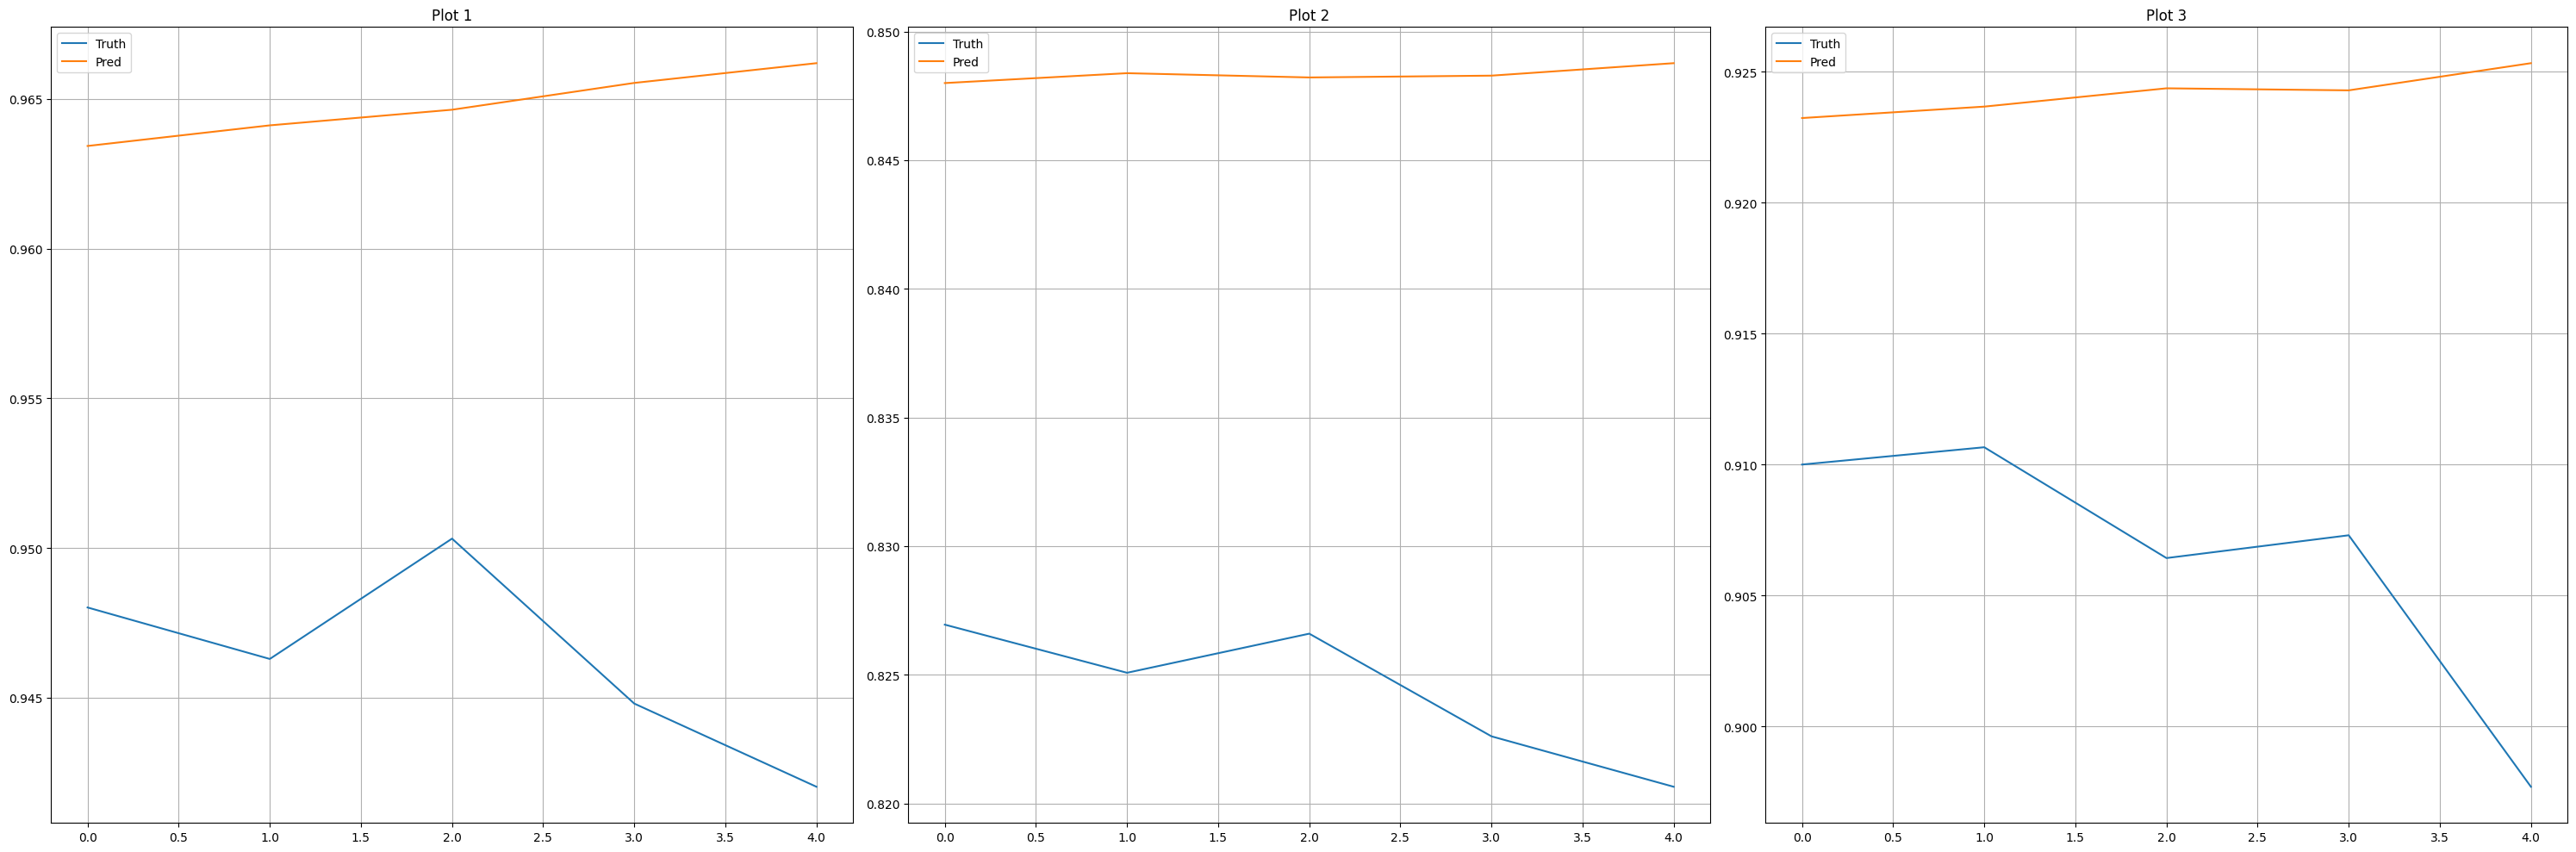

In [20]:
truth_prophet = [df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))]
pred_prophet = [prophet_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_models))]
draw_pred_truth(truth_prophet, pred_prophet)

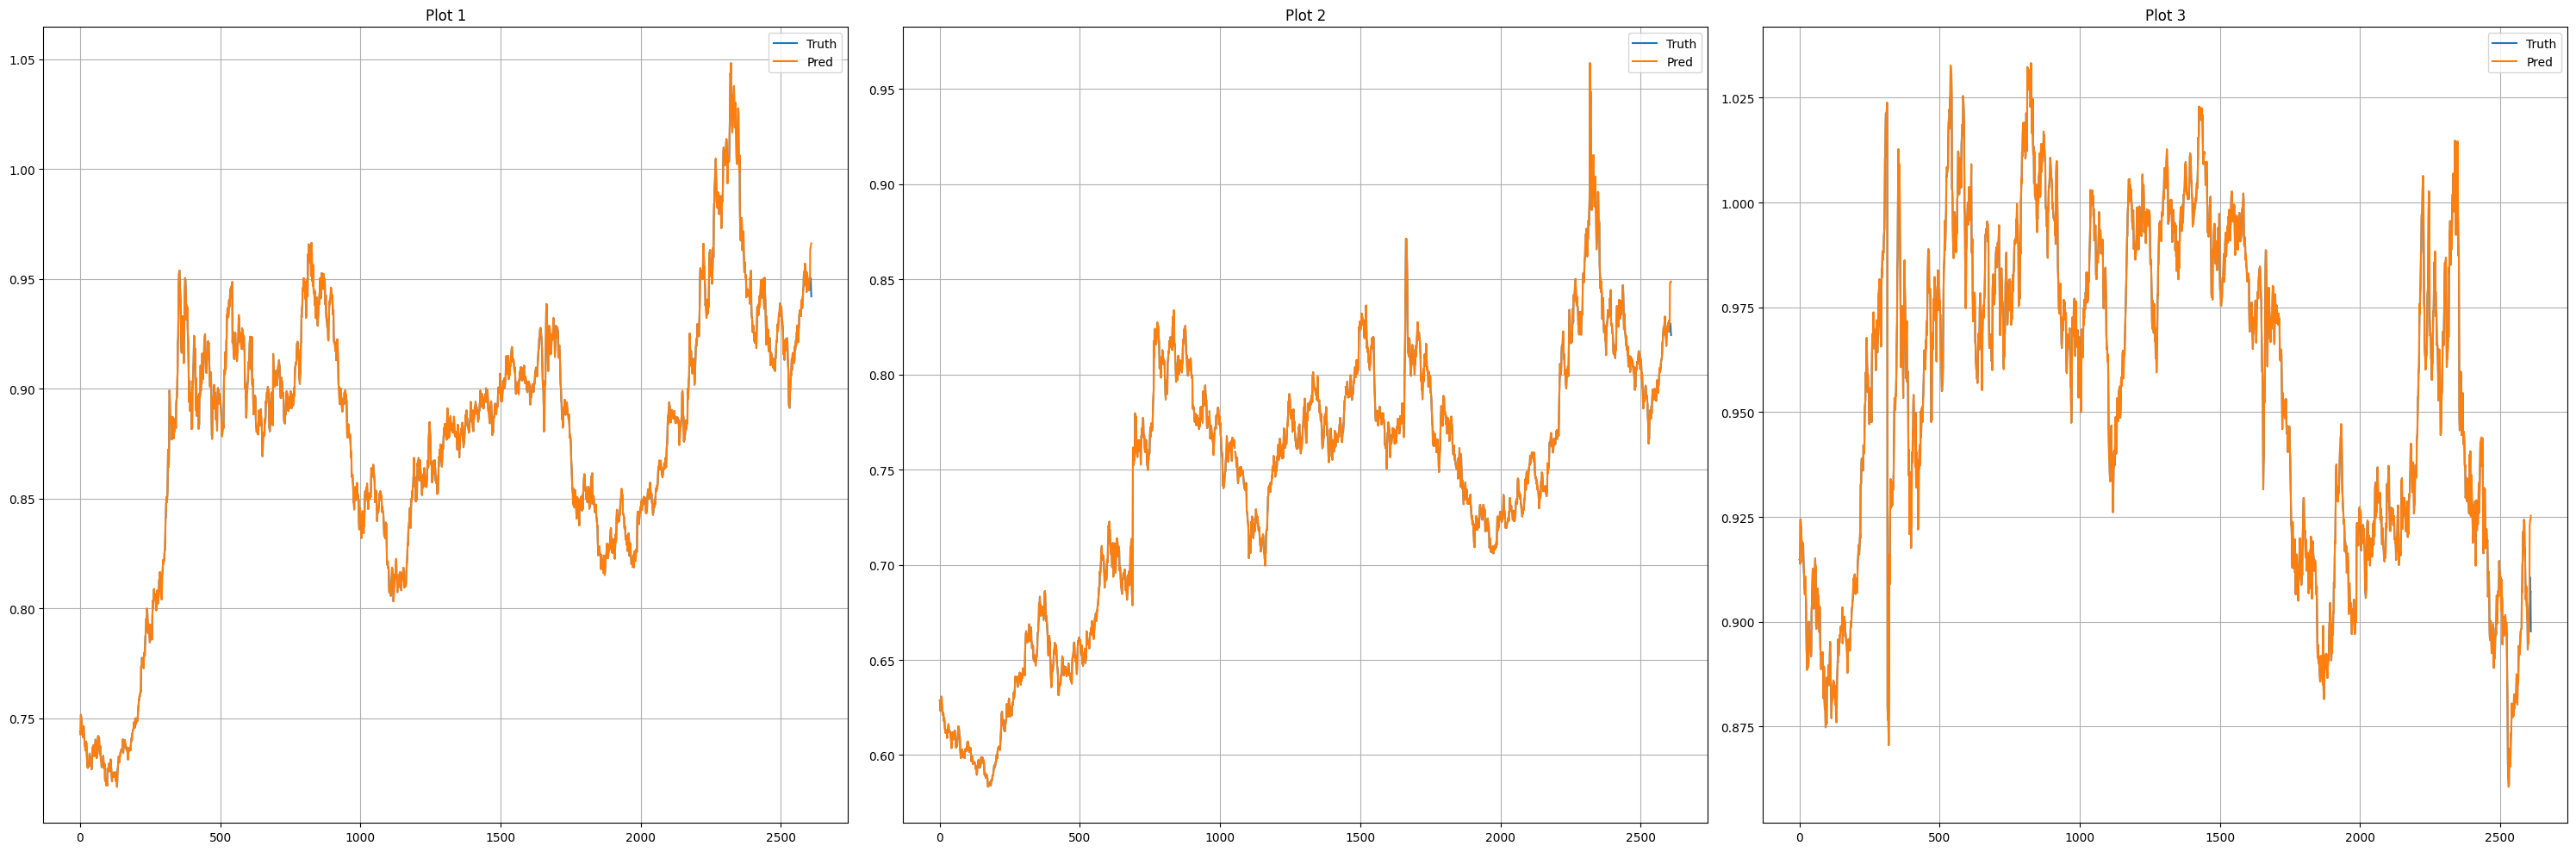

In [21]:
train_pred_prophet = [np.concatenate((df_train_prophet[i]['y'].to_numpy(), prophet_models[i][1]['yhat'].to_numpy()), axis=0) for i in range(len(df_train_prophet))]
# print(len(train_pred_prophet))
draw_pred_truth([df_all_prophet[i]['y'].to_numpy() for i in range(len(df_all_prophet))], train_pred_prophet)

## Hyper parameter tunning to find the best model

In [22]:
# Define a range of hyperparameter values to search
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1], # default 0.05
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10], # default 10
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10], # default 10
}
best_mse = float('inf')
best_params = {}
ground_truth = [df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))]

# Iterate through the parameter grid and find the best hyperparameters
for params in ParameterGrid(param_grid):
    print(f"params is {params}")
    para_models = []
    for curve_data in df_train_prophet:
        # Create a Prophet model with the current hyperparameters
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale']
        )
        
        # Fit the model on the training data
        model.fit(curve_data)
        
        last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
        # Create a date range for the next 5 trading days, excluding weekends
        future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
        # Create a DataFrame with these dates
        future_df = pd.DataFrame({'ds': future_dates})
        # Make predictions
        forecast = model.predict(future_df)

        para_models.append((model, forecast))
    _, mse = calculate_mse(ground_truth, [para_models[i][1]['yhat'].to_numpy() for i in range(len(para_models))])
    print(f"MSE is {mse}")
    # Check if the current set of hyperparameters results in a better model
    if mse < best_mse:
        best_mse = mse
        best_params = params

print("Best Hyperparameters:")
print(best_params)
print("Best MSE:", best_mse)

11:52:54 - cmdstanpy - INFO - Chain [1] start processing


params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


11:52:55 - cmdstanpy - INFO - Chain [1] done processing
11:52:55 - cmdstanpy - INFO - Chain [1] start processing
11:52:55 - cmdstanpy - INFO - Chain [1] done processing
11:52:55 - cmdstanpy - INFO - Chain [1] start processing
11:52:55 - cmdstanpy - INFO - Chain [1] done processing
11:52:56 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018826512071919203
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


11:52:56 - cmdstanpy - INFO - Chain [1] done processing
11:52:56 - cmdstanpy - INFO - Chain [1] start processing
11:52:56 - cmdstanpy - INFO - Chain [1] done processing
11:52:56 - cmdstanpy - INFO - Chain [1] start processing
11:52:57 - cmdstanpy - INFO - Chain [1] done processing
11:52:57 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018796881487143258
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


11:52:57 - cmdstanpy - INFO - Chain [1] done processing
11:52:57 - cmdstanpy - INFO - Chain [1] start processing
11:52:57 - cmdstanpy - INFO - Chain [1] done processing
11:52:57 - cmdstanpy - INFO - Chain [1] start processing
11:52:58 - cmdstanpy - INFO - Chain [1] done processing
11:52:58 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01881974051981611
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


11:52:58 - cmdstanpy - INFO - Chain [1] done processing
11:52:58 - cmdstanpy - INFO - Chain [1] start processing
11:52:58 - cmdstanpy - INFO - Chain [1] done processing
11:52:58 - cmdstanpy - INFO - Chain [1] start processing
11:52:59 - cmdstanpy - INFO - Chain [1] done processing
11:52:59 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018592488828151323
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


11:52:59 - cmdstanpy - INFO - Chain [1] done processing
11:52:59 - cmdstanpy - INFO - Chain [1] start processing
11:52:59 - cmdstanpy - INFO - Chain [1] done processing
11:53:00 - cmdstanpy - INFO - Chain [1] start processing
11:53:00 - cmdstanpy - INFO - Chain [1] done processing
11:53:00 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018826512071919203
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


11:53:00 - cmdstanpy - INFO - Chain [1] done processing
11:53:00 - cmdstanpy - INFO - Chain [1] start processing
11:53:01 - cmdstanpy - INFO - Chain [1] done processing
11:53:01 - cmdstanpy - INFO - Chain [1] start processing
11:53:01 - cmdstanpy - INFO - Chain [1] done processing
11:53:01 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018796881487143258
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


11:53:01 - cmdstanpy - INFO - Chain [1] done processing
11:53:01 - cmdstanpy - INFO - Chain [1] start processing
11:53:02 - cmdstanpy - INFO - Chain [1] done processing
11:53:02 - cmdstanpy - INFO - Chain [1] start processing
11:53:02 - cmdstanpy - INFO - Chain [1] done processing
11:53:02 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01881974051981611
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10}


11:53:02 - cmdstanpy - INFO - Chain [1] done processing
11:53:02 - cmdstanpy - INFO - Chain [1] start processing
11:53:03 - cmdstanpy - INFO - Chain [1] done processing
11:53:03 - cmdstanpy - INFO - Chain [1] start processing
11:53:03 - cmdstanpy - INFO - Chain [1] done processing
11:53:03 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018592488828151323
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


11:53:03 - cmdstanpy - INFO - Chain [1] done processing
11:53:03 - cmdstanpy - INFO - Chain [1] start processing
11:53:04 - cmdstanpy - INFO - Chain [1] done processing
11:53:04 - cmdstanpy - INFO - Chain [1] start processing
11:53:04 - cmdstanpy - INFO - Chain [1] done processing
11:53:04 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018826512071919203
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}


11:53:04 - cmdstanpy - INFO - Chain [1] done processing
11:53:04 - cmdstanpy - INFO - Chain [1] start processing
11:53:05 - cmdstanpy - INFO - Chain [1] done processing
11:53:05 - cmdstanpy - INFO - Chain [1] start processing
11:53:05 - cmdstanpy - INFO - Chain [1] done processing
11:53:05 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018796881487143258
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


11:53:06 - cmdstanpy - INFO - Chain [1] done processing
11:53:06 - cmdstanpy - INFO - Chain [1] start processing
11:53:06 - cmdstanpy - INFO - Chain [1] done processing
11:53:06 - cmdstanpy - INFO - Chain [1] start processing
11:53:06 - cmdstanpy - INFO - Chain [1] done processing
11:53:06 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01881974051981611
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10}


11:53:06 - cmdstanpy - INFO - Chain [1] done processing
11:53:07 - cmdstanpy - INFO - Chain [1] start processing
11:53:07 - cmdstanpy - INFO - Chain [1] done processing
11:53:07 - cmdstanpy - INFO - Chain [1] start processing
11:53:07 - cmdstanpy - INFO - Chain [1] done processing
11:53:07 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018592488828151323
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


11:53:08 - cmdstanpy - INFO - Chain [1] done processing
11:53:08 - cmdstanpy - INFO - Chain [1] start processing
11:53:08 - cmdstanpy - INFO - Chain [1] done processing
11:53:08 - cmdstanpy - INFO - Chain [1] start processing
11:53:08 - cmdstanpy - INFO - Chain [1] done processing
11:53:08 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018826512071919203
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1}


11:53:09 - cmdstanpy - INFO - Chain [1] done processing
11:53:09 - cmdstanpy - INFO - Chain [1] start processing
11:53:09 - cmdstanpy - INFO - Chain [1] done processing
11:53:09 - cmdstanpy - INFO - Chain [1] start processing
11:53:09 - cmdstanpy - INFO - Chain [1] done processing
11:53:10 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018796881487143258
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1.0}


11:53:10 - cmdstanpy - INFO - Chain [1] done processing
11:53:10 - cmdstanpy - INFO - Chain [1] start processing
11:53:10 - cmdstanpy - INFO - Chain [1] done processing
11:53:10 - cmdstanpy - INFO - Chain [1] start processing
11:53:11 - cmdstanpy - INFO - Chain [1] done processing
11:53:11 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01881974051981611
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


11:53:11 - cmdstanpy - INFO - Chain [1] done processing
11:53:11 - cmdstanpy - INFO - Chain [1] start processing
11:53:11 - cmdstanpy - INFO - Chain [1] done processing
11:53:11 - cmdstanpy - INFO - Chain [1] start processing
11:53:11 - cmdstanpy - INFO - Chain [1] done processing
11:53:12 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018592488828151323
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


11:53:12 - cmdstanpy - INFO - Chain [1] done processing
11:53:12 - cmdstanpy - INFO - Chain [1] start processing
11:53:13 - cmdstanpy - INFO - Chain [1] done processing
11:53:13 - cmdstanpy - INFO - Chain [1] start processing
11:53:14 - cmdstanpy - INFO - Chain [1] done processing
11:53:14 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01589374619980191
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


11:53:14 - cmdstanpy - INFO - Chain [1] done processing
11:53:15 - cmdstanpy - INFO - Chain [1] start processing
11:53:15 - cmdstanpy - INFO - Chain [1] done processing
11:53:15 - cmdstanpy - INFO - Chain [1] start processing
11:53:16 - cmdstanpy - INFO - Chain [1] done processing
11:53:16 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015839599902913778
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


11:53:17 - cmdstanpy - INFO - Chain [1] done processing
11:53:17 - cmdstanpy - INFO - Chain [1] start processing
11:53:17 - cmdstanpy - INFO - Chain [1] done processing
11:53:17 - cmdstanpy - INFO - Chain [1] start processing
11:53:18 - cmdstanpy - INFO - Chain [1] done processing
11:53:18 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015960884585009272
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


11:53:18 - cmdstanpy - INFO - Chain [1] done processing
11:53:18 - cmdstanpy - INFO - Chain [1] start processing
11:53:19 - cmdstanpy - INFO - Chain [1] done processing
11:53:19 - cmdstanpy - INFO - Chain [1] start processing
11:53:20 - cmdstanpy - INFO - Chain [1] done processing
11:53:20 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01597005329226497
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


11:53:20 - cmdstanpy - INFO - Chain [1] done processing
11:53:20 - cmdstanpy - INFO - Chain [1] start processing
11:53:21 - cmdstanpy - INFO - Chain [1] done processing
11:53:21 - cmdstanpy - INFO - Chain [1] start processing
11:53:22 - cmdstanpy - INFO - Chain [1] done processing
11:53:22 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01589374619980191
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


11:53:23 - cmdstanpy - INFO - Chain [1] done processing
11:53:23 - cmdstanpy - INFO - Chain [1] start processing
11:53:23 - cmdstanpy - INFO - Chain [1] done processing
11:53:23 - cmdstanpy - INFO - Chain [1] start processing
11:53:24 - cmdstanpy - INFO - Chain [1] done processing
11:53:24 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015839599902913778
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


11:53:25 - cmdstanpy - INFO - Chain [1] done processing
11:53:25 - cmdstanpy - INFO - Chain [1] start processing
11:53:25 - cmdstanpy - INFO - Chain [1] done processing
11:53:25 - cmdstanpy - INFO - Chain [1] start processing
11:53:26 - cmdstanpy - INFO - Chain [1] done processing
11:53:26 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015960884585009272
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10}


11:53:26 - cmdstanpy - INFO - Chain [1] done processing
11:53:27 - cmdstanpy - INFO - Chain [1] start processing
11:53:27 - cmdstanpy - INFO - Chain [1] done processing
11:53:27 - cmdstanpy - INFO - Chain [1] start processing
11:53:28 - cmdstanpy - INFO - Chain [1] done processing
11:53:28 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01597005329226497
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


11:53:28 - cmdstanpy - INFO - Chain [1] done processing
11:53:28 - cmdstanpy - INFO - Chain [1] start processing
11:53:29 - cmdstanpy - INFO - Chain [1] done processing
11:53:29 - cmdstanpy - INFO - Chain [1] start processing
11:53:30 - cmdstanpy - INFO - Chain [1] done processing
11:53:30 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01589374619980191
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}


11:53:31 - cmdstanpy - INFO - Chain [1] done processing
11:53:31 - cmdstanpy - INFO - Chain [1] start processing
11:53:31 - cmdstanpy - INFO - Chain [1] done processing
11:53:31 - cmdstanpy - INFO - Chain [1] start processing
11:53:32 - cmdstanpy - INFO - Chain [1] done processing
11:53:32 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015839599902913778
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


11:53:33 - cmdstanpy - INFO - Chain [1] done processing
11:53:33 - cmdstanpy - INFO - Chain [1] start processing
11:53:33 - cmdstanpy - INFO - Chain [1] done processing
11:53:33 - cmdstanpy - INFO - Chain [1] start processing
11:53:34 - cmdstanpy - INFO - Chain [1] done processing
11:53:34 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015960884585009272
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10}


11:53:35 - cmdstanpy - INFO - Chain [1] done processing
11:53:35 - cmdstanpy - INFO - Chain [1] start processing
11:53:35 - cmdstanpy - INFO - Chain [1] done processing
11:53:35 - cmdstanpy - INFO - Chain [1] start processing
11:53:36 - cmdstanpy - INFO - Chain [1] done processing
11:53:36 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01597005329226497
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


11:53:36 - cmdstanpy - INFO - Chain [1] done processing
11:53:37 - cmdstanpy - INFO - Chain [1] start processing
11:53:37 - cmdstanpy - INFO - Chain [1] done processing
11:53:37 - cmdstanpy - INFO - Chain [1] start processing
11:53:38 - cmdstanpy - INFO - Chain [1] done processing
11:53:38 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01589374619980191
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1}


11:53:39 - cmdstanpy - INFO - Chain [1] done processing
11:53:39 - cmdstanpy - INFO - Chain [1] start processing
11:53:39 - cmdstanpy - INFO - Chain [1] done processing
11:53:39 - cmdstanpy - INFO - Chain [1] start processing
11:53:40 - cmdstanpy - INFO - Chain [1] done processing
11:53:40 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015839599902913778
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1.0}


11:53:41 - cmdstanpy - INFO - Chain [1] done processing
11:53:41 - cmdstanpy - INFO - Chain [1] start processing
11:53:41 - cmdstanpy - INFO - Chain [1] done processing
11:53:41 - cmdstanpy - INFO - Chain [1] start processing
11:53:42 - cmdstanpy - INFO - Chain [1] done processing
11:53:42 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015960884585009272
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


11:53:43 - cmdstanpy - INFO - Chain [1] done processing
11:53:43 - cmdstanpy - INFO - Chain [1] start processing
11:53:43 - cmdstanpy - INFO - Chain [1] done processing
11:53:43 - cmdstanpy - INFO - Chain [1] start processing
11:53:44 - cmdstanpy - INFO - Chain [1] done processing
11:53:44 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01597005329226497
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


11:53:45 - cmdstanpy - INFO - Chain [1] done processing
11:53:45 - cmdstanpy - INFO - Chain [1] start processing
11:53:45 - cmdstanpy - INFO - Chain [1] done processing
11:53:45 - cmdstanpy - INFO - Chain [1] start processing
11:53:46 - cmdstanpy - INFO - Chain [1] done processing
11:53:46 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01525076903032153
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


11:53:47 - cmdstanpy - INFO - Chain [1] done processing
11:53:47 - cmdstanpy - INFO - Chain [1] start processing
11:53:48 - cmdstanpy - INFO - Chain [1] done processing
11:53:48 - cmdstanpy - INFO - Chain [1] start processing
11:53:49 - cmdstanpy - INFO - Chain [1] done processing
11:53:49 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015284142788935506
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


11:53:50 - cmdstanpy - INFO - Chain [1] done processing
11:53:50 - cmdstanpy - INFO - Chain [1] start processing
11:53:51 - cmdstanpy - INFO - Chain [1] done processing
11:53:51 - cmdstanpy - INFO - Chain [1] start processing
11:53:51 - cmdstanpy - INFO - Chain [1] done processing
11:53:52 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015296589049467662
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


11:53:52 - cmdstanpy - INFO - Chain [1] done processing
11:53:52 - cmdstanpy - INFO - Chain [1] start processing
11:53:53 - cmdstanpy - INFO - Chain [1] done processing
11:53:53 - cmdstanpy - INFO - Chain [1] start processing
11:53:54 - cmdstanpy - INFO - Chain [1] done processing
11:53:54 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015300558136363867
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


11:53:55 - cmdstanpy - INFO - Chain [1] done processing
11:53:55 - cmdstanpy - INFO - Chain [1] start processing
11:53:55 - cmdstanpy - INFO - Chain [1] done processing
11:53:55 - cmdstanpy - INFO - Chain [1] start processing
11:53:56 - cmdstanpy - INFO - Chain [1] done processing
11:53:56 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01525076903032153
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


11:53:57 - cmdstanpy - INFO - Chain [1] done processing
11:53:57 - cmdstanpy - INFO - Chain [1] start processing
11:53:58 - cmdstanpy - INFO - Chain [1] done processing
11:53:58 - cmdstanpy - INFO - Chain [1] start processing
11:53:59 - cmdstanpy - INFO - Chain [1] done processing
11:53:59 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015284142788935506
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


11:54:00 - cmdstanpy - INFO - Chain [1] done processing
11:54:00 - cmdstanpy - INFO - Chain [1] start processing
11:54:01 - cmdstanpy - INFO - Chain [1] done processing
11:54:01 - cmdstanpy - INFO - Chain [1] start processing
11:54:01 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015296589049467662
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10}


11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:03 - cmdstanpy - INFO - Chain [1] done processing
11:54:03 - cmdstanpy - INFO - Chain [1] start processing
11:54:04 - cmdstanpy - INFO - Chain [1] done processing
11:54:04 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015300558136363867
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


11:54:05 - cmdstanpy - INFO - Chain [1] done processing
11:54:05 - cmdstanpy - INFO - Chain [1] start processing
11:54:05 - cmdstanpy - INFO - Chain [1] done processing
11:54:06 - cmdstanpy - INFO - Chain [1] start processing
11:54:06 - cmdstanpy - INFO - Chain [1] done processing
11:54:06 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01525076903032153
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}


11:54:07 - cmdstanpy - INFO - Chain [1] done processing
11:54:07 - cmdstanpy - INFO - Chain [1] start processing
11:54:08 - cmdstanpy - INFO - Chain [1] done processing
11:54:08 - cmdstanpy - INFO - Chain [1] start processing
11:54:09 - cmdstanpy - INFO - Chain [1] done processing
11:54:09 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015284142788935506
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


11:54:10 - cmdstanpy - INFO - Chain [1] done processing
11:54:10 - cmdstanpy - INFO - Chain [1] start processing
11:54:11 - cmdstanpy - INFO - Chain [1] done processing
11:54:11 - cmdstanpy - INFO - Chain [1] start processing
11:54:12 - cmdstanpy - INFO - Chain [1] done processing
11:54:12 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015296589049467662
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10}


11:54:12 - cmdstanpy - INFO - Chain [1] done processing
11:54:12 - cmdstanpy - INFO - Chain [1] start processing
11:54:13 - cmdstanpy - INFO - Chain [1] done processing
11:54:13 - cmdstanpy - INFO - Chain [1] start processing
11:54:14 - cmdstanpy - INFO - Chain [1] done processing
11:54:14 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015300558136363867
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


11:54:15 - cmdstanpy - INFO - Chain [1] done processing
11:54:15 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1] done processing
11:54:16 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1] done processing
11:54:17 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01525076903032153
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1}


11:54:17 - cmdstanpy - INFO - Chain [1] done processing
11:54:17 - cmdstanpy - INFO - Chain [1] start processing
11:54:18 - cmdstanpy - INFO - Chain [1] done processing
11:54:18 - cmdstanpy - INFO - Chain [1] start processing
11:54:19 - cmdstanpy - INFO - Chain [1] done processing
11:54:19 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015284142788935506
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1.0}


11:54:20 - cmdstanpy - INFO - Chain [1] done processing
11:54:20 - cmdstanpy - INFO - Chain [1] start processing
11:54:21 - cmdstanpy - INFO - Chain [1] done processing
11:54:21 - cmdstanpy - INFO - Chain [1] start processing
11:54:22 - cmdstanpy - INFO - Chain [1] done processing
11:54:22 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015296589049467662
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


11:54:22 - cmdstanpy - INFO - Chain [1] done processing
11:54:22 - cmdstanpy - INFO - Chain [1] start processing
11:54:23 - cmdstanpy - INFO - Chain [1] done processing
11:54:23 - cmdstanpy - INFO - Chain [1] start processing
11:54:24 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015300558136363867
Best Hyperparameters:
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
Best MSE: 0.01525076903032153


In [23]:
# Best Hyperparameters:
# {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}
# Best MSE: 0.07732153857925472

## Now predict using the best model 

11:54:24 - cmdstanpy - INFO - Chain [1] start processing
11:54:25 - cmdstanpy - INFO - Chain [1] done processing
11:54:25 - cmdstanpy - INFO - Chain [1] start processing
11:54:26 - cmdstanpy - INFO - Chain [1] done processing
11:54:26 - cmdstanpy - INFO - Chain [1] start processing
11:54:26 - cmdstanpy - INFO - Chain [1] done processing


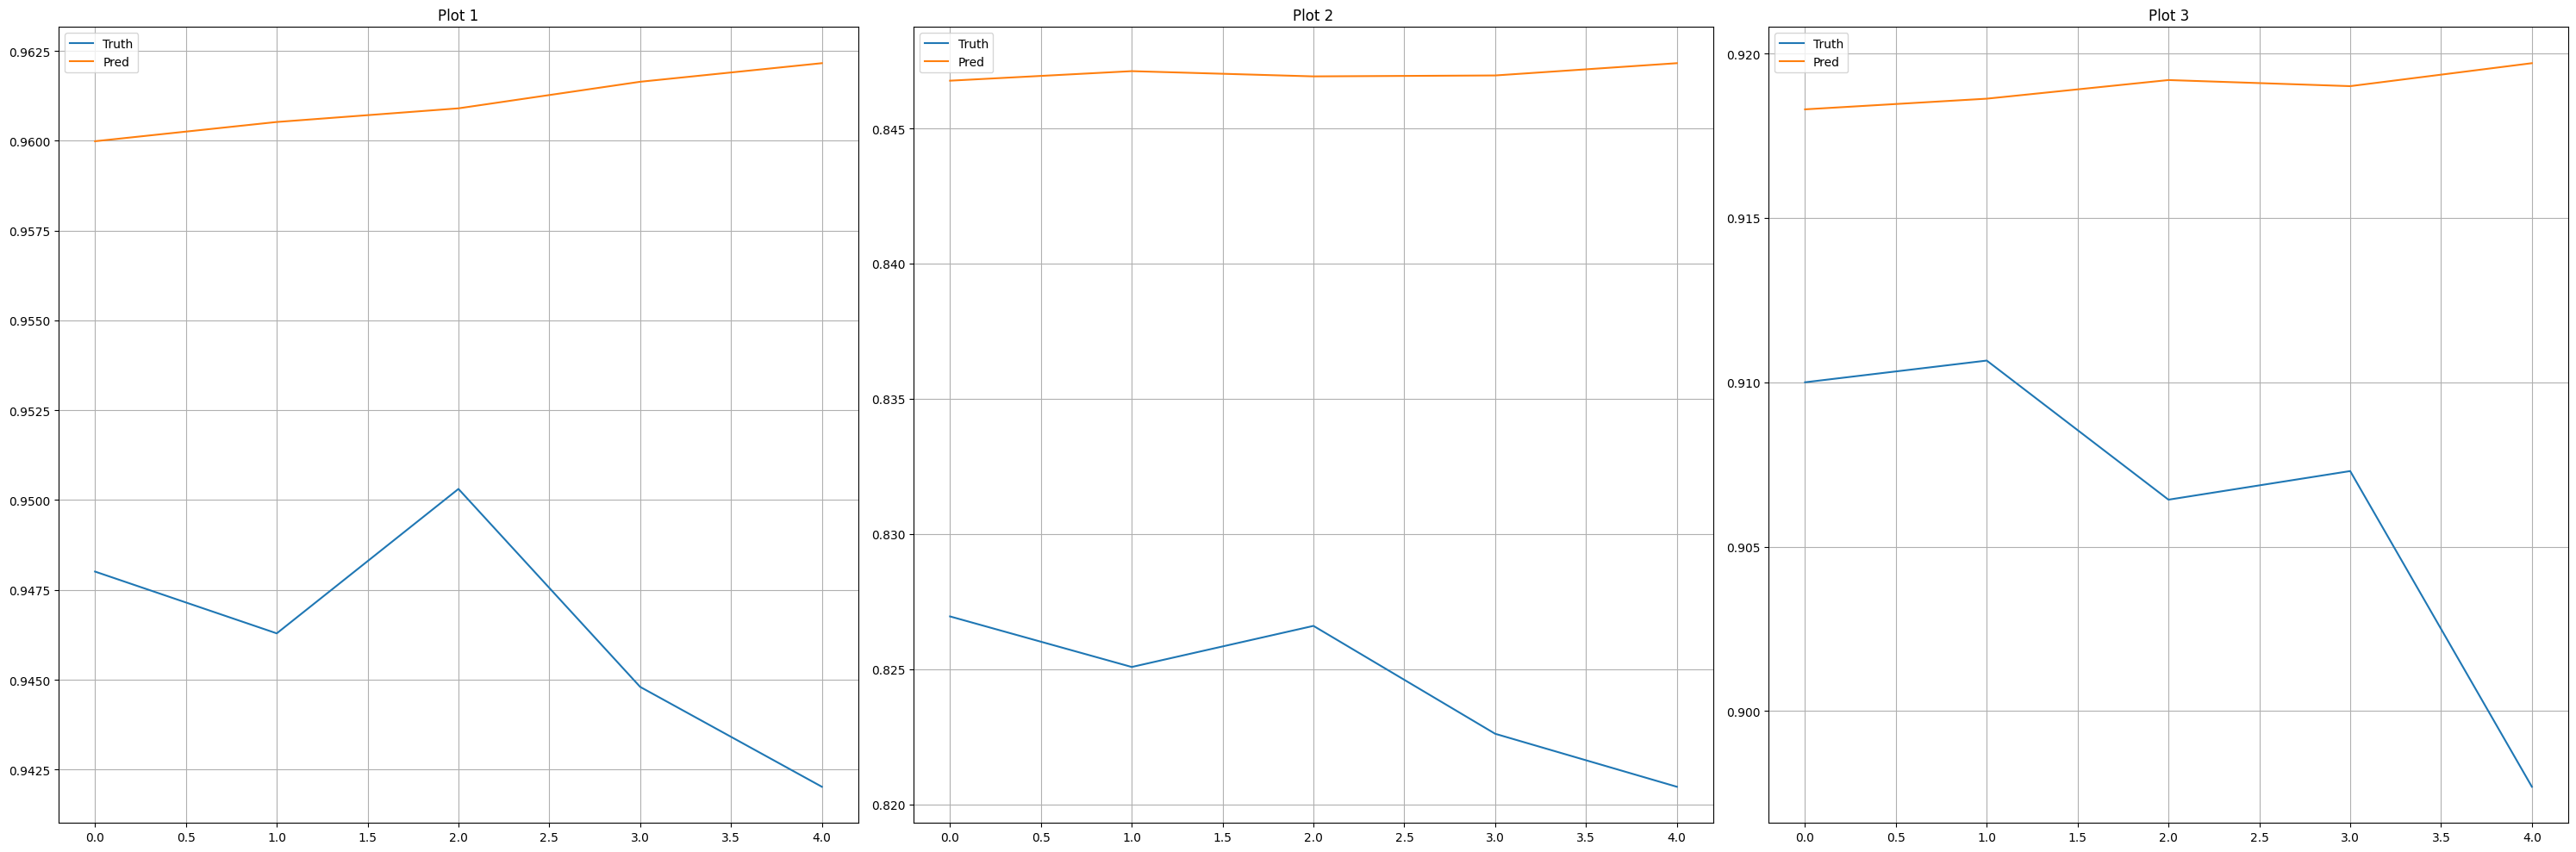

In [24]:
prophet_models = []

for curve_data in df_train_prophet:
    model = Prophet(
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=0.01,
        holidays_prior_scale=0.1
    )
    model.fit(curve_data)

    last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
    # Create a date range for the next 5 trading days, excluding weekends
    future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
    # Create a DataFrame with these dates
    future_df = pd.DataFrame({'ds': future_dates})
    # Make predictions
    forecast = model.predict(future_df)
    # Store the model and its forecast in a list
    prophet_models.append((model, forecast))

truth_prophet = [df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))]
pred_prophet = [prophet_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_models))]
draw_pred_truth(truth_prophet, pred_prophet)

## Re-train the model with best parameter and data till 2023-11-03. For midterm 

In [27]:
prophet_midterm_models = []

for curve_data in df_all_prophet:
    model = Prophet(
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=0.01,
        holidays_prior_scale=0.1
    )
    model.fit(curve_data)

    last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
    # Create a date range for the next 5 trading days, excluding weekends
    future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
    # print(future_dates)
    # Create a DataFrame with these dates
    future_df = pd.DataFrame({'ds': future_dates})
    # Make predictions
    forecast = model.predict(future_df)
    # Store the model and its forecast in a list
    prophet_midterm_models.append((model, forecast))

11:56:54 - cmdstanpy - INFO - Chain [1] start processing
11:56:55 - cmdstanpy - INFO - Chain [1] done processing
11:56:55 - cmdstanpy - INFO - Chain [1] start processing
11:56:56 - cmdstanpy - INFO - Chain [1] done processing
11:56:56 - cmdstanpy - INFO - Chain [1] start processing
11:56:57 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
pred_prophet_midterm = [prophet_midterm_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_midterm_models))]

In [31]:
pred_prophet_midterm

[array([0.96107363, 0.96163631, 0.96200946, 0.96267322, 0.96307393]),
 array([0.84518852, 0.84553818, 0.84531898, 0.84528521, 0.84565037]),
 array([0.91868502, 0.91948651, 0.91987329, 0.92045898, 0.92027328])]

# ARIMA

In [ ]:
#split train_dataset into train_dataset and validation_dataset, we set validation_dataset size to be 5, which conforms to test_dataset size
train_size=len(df_train[0][:-5])

train=np.array(df_train[0]['rate'])[:train_size]
val=np.array(df_train[0]['rate'])[train_size:]

In [ ]:
print(train.shape,val.shape)

In [ ]:
# train ARIMA model
from statsmodels.tsa.arima.model import ARIMA

#Since we have already applied difference on data, we set d=0 here.
p,d,q=1,2,1
model = ARIMA(train, order=(p, d, q))
result = model.fit()
print(result.summary())

In [ ]:
train

In [ ]:
# prediction
train_predictions = result.predict(start=1, end=train.shape[0])
print(train_predictions)

val_predictions = result.get_forecast(len(val)).predicted_mean
print(val_predictions)

In [ ]:
val

In [ ]:
plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

In [ ]:
plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.xlim(len(train), len(train)+len(val))
plt.ylim(0.93, 0.96)
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(train_predictions,train)
val_mse = mean_squared_error(val_predictions, val)

print("train_MSE:", train_mse)
print("val_MSE:", val_mse)

## Fine-tuning

In [ ]:
#gird search
min_val_mse=1e9
optimal_p=1
optimal_d=1
optimal_q=1
for p in range(1,6):
    for d in range(1,3):
        for q in range(1,6):
            model = ARIMA(train, order=(p, d, q))
            result = model.fit()
            train_predictions = result.predict(start=1, end=train.shape[0])
            val_predictions = result.get_forecast(len(val)).predicted_mean
            train_mse = mean_squared_error(train_predictions,train)
            val_mse = mean_squared_error(val_predictions, val)
            if (val_mse<min_val_mse):
                min_val_mse=val_mse
                optimal_p=p
                optimal_q=q
                optimal_d=d
            print(f"p={p},d={d},q={q}:")
            print("train_MSE:", train_mse)
            print("val_MSE:", val_mse)
            print("-------------------------------------------------------------")

In [ ]:
print(optimal_p,optimal_d,optimal_q)

In [ ]:
#visualize the best case
model = ARIMA(train, order=(optimal_p, optimal_d, optimal_q))
result = model.fit()

train_predictions = result.predict(start=1, end=train.shape[0])
val_predictions = result.get_forecast(len(val)).predicted_mean

plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

## Modularization

In [ ]:
def fine_tune(df):
    #split dataset
    train_size=len(df[:-5])

    train=np.array(df['rate'])[:train_size]
    val=np.array(df['rate'])[train_size:]
    
    #fine-tuning
    min_val_mse=1e9
    optimal_p=1
    optimal_d=1
    optimal_q=1
    for p in range(1,6):
        for d in range(1,3):
            for q in range(1,6):
                model = ARIMA(train, order=(p, d, q))
                result = model.fit()
                train_predictions = result.predict(start=1, end=train.shape[0])
                val_predictions = result.get_forecast(len(val)).predicted_mean
                train_mse = mean_squared_error(train_predictions,train)
                val_mse = mean_squared_error(val_predictions, val)
                if (val_mse<min_val_mse):
                    min_val_mse=val_mse
                    optimal_p=p
                    optimal_q=q
                    optimal_d=d
    
    return optimal_p,optimal_d,optimal_q

In [ ]:
#find best hyper parameters for each dataset
best_parameters=[]
for i in range(len(filepath)):
    best_parameters.append(fine_tune(df_train[i]))

In [ ]:
print(best_parameters)

In [ ]:
def get_best_model(df,best_parameter):
    #train using the whole training dataset
    train=np.array(df['rate'])

    
    #visualize the best case
    optimal_p, optimal_d, optimal_q=best_parameter
    model = ARIMA(train, order=(optimal_p, optimal_d, optimal_q))
    result = model.fit()

    train_predictions = result.predict(start=1, end=train.shape[0])

    plt.plot(train,label='training')
    plt.plot(train_predictions,label='train_prediction')
    plt.show()

    return result

In [ ]:
models=[]
for i in range(len(filepath)):
    models.append(get_best_model(df_train[i],best_parameters[i]))

## Compute Max Profit

In [ ]:
ARIMA_predictions=[]
for i in range(len(filepath)):
    ARIMA_predictions.append(models[i].get_forecast(len(df_test[i])).predicted_mean)

In [ ]:
ARIMA_predictions=np.array(ARIMA_predictions)
ARIMA_predictions

In [ ]:
true_rate=[]
for i in range(len(filepath)):
    true_rate.append(np.array(df_test[i]).squeeze())

In [ ]:
true_rate=np.array(true_rate)
true_rate

In [ ]:
def get_max_profit(rate):
    #We initially have 1000 dollars
    principal=1000
    # 5 days in total, we have 4 chances to make a profit
    for i in range(4):
        #Here, we initialize rate_increase to be 1. This is to prevent elements in rate_increase are all smaller than 1.
        rate_increase=np.array([1])
        #Here, we only need the first three predictions.
        for j in range(3):
            rate_increase=np.append(rate_increase,rate[j][i+1]/rate[j][-1])
        max_rate_increase=np.max(rate_increase)
        principal*=max_rate_increase
    return principal

In [ ]:
predict_profit=get_max_profit(ARIMA_predictions)
true_profit=get_max_profit(true_rate)
print(predict_profit,true_profit)

In [ ]:
#Compute MSE between the max profit computed via ARIMA and the actual profit 
profit_mse = (predict_profit-true_profit)**2
print("MSE between the max profit computed via ARIMA and the actual profit is:", profit_mse)

# SARIMA

In [ ]:
#seperates data set
train_size=len(df_train[0][:-5])

train=np.array(df_train[0]['rate'])[:train_size]
val=np.array(df_train[0]['rate'])[train_size:]

In [ ]:
# train SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# initial parameters
sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1,1,1,12))
result = sarima.fit()
train_prediction = result.predict()
val_predictions = result.get_forecast(len(val)).predicted_mean

plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

## Error Calculation

In [ ]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(result.predict(),train)
val_mse = mean_squared_error(val_predictions, val)

## Fine tuning

In [ ]:
def get_best_model_sarima(df,best_parameter):
    #train using the whole training dataset
    train=np.array(df['rate'])

    
    #visualize the best case
    optimal_p, optimal_d, optimal_q=best_parameter
    model =  SARIMAX(train, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(p,d,q,12))
    result = model.fit()

    train_predictions = result.predict(start=1, end=train.shape[0])

    plt.plot(train,label='training')
    plt.plot(train_predictions,label='train_prediction')
    plt.show()

    return result

In [ ]:
def fine_tune_sarima(df):
    #split dataset
    train_size=len(df[:-5])

    train=np.array(df['rate'])[:train_size]
    val=np.array(df['rate'])[train_size:]
    
    #fine-tuning
                    
    q_optimized = 0
    d_optimized = 0
    p_optimized = 0

    smallest_error = -1
    for q in range(1, 3):
        for d in range(1, 3):
            for p in range(1, 3):
                sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(p,d,q,12))
                sarima_model.fit()
                train_prediction = result.predict()
                val_predictions = result.get_forecast(len(val)).predicted_mean
                if (smallest_error == -1):
                    smallest_error = mean_squared_error(val_predictions, val)
                else:
                    err = mean_squared_error(val_predictions, val)
                    if (err < smallest_error):
                        smallest_error = err
                        q_optimized = q
                        d_optimized = d
                        p_optimized = p
    
    return p_optimized,d_optimized,q_optimized

In [ ]:
#find best hyper parameters for each dataset
best_parameters_sarima=[]
for i in range(3):
    best_parameters_sarima.append(fine_tune_sarima(df_train[i]))

models_sarima=[]
for i in range(3):
    models_sarima.append(get_best_model_sarima(df_train[i],best_parameters_sarima[i]))


In [ ]:
SARIMA_predictions=[]
for i in range(3):
    SARIMA_predictions.append(models_sarima[i].get_forecast(len(df_test[i])).predicted_mean)

# Model Assembling

In [ ]:
pred_prophet=np.array(pred_prophet)
pred_prophet

In [ ]:
ARIMA_predictions

In [ ]:
SARIMA_predictions=np.array(SARIMA_predictions)
SARIMA_predictions

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

weights = []

for i in range(len(filepath)):
    x1=pred_prophet[i]
    x2=ARIMA_predictions[i]
    x3=SARIMA_predictions[i]

    X_train = np.column_stack((x1, x2, x3))
    y_train = true_rate[i]
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    weights.append(model.coef_)

In [ ]:
print(weights)